In [128]:
import csv
import os
import matplotlib as plt
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from importlib import resources
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import time
from selenium import webdriver
from IPython.display import Image

In [129]:
file_path = "Normalized_Tables\Main_data_Table.csv"
main_data = pd.read_csv(file_path)
main_data

,IndicatorCode,Country_Code,Gender,Age_Group,Planning_Value_Rate,FactComments,Language_Code,Starting_Year,Year_Ending,Year_Group,PeriodRangeID
0,SDGFPALL,UGA,Female,15-49 years,65.5,The global indicator represents all women of r...,EN,2021,2021,2021-2021,1
1,SDGFPALL,NER,Female,15-49 years,36.9,Niger 2021 PMA Survey Phase 1,EN,2020,2021,2020-2021,1
2,SDGFPALL,BFA,Female,15-49 years,58.2,Burkina Faso 2021 PMA Survey Phase 2,EN,2020,2021,2020-2021,1
3,SDGFPALL,VNM,Female,15-49 years,72.1,The global indicator represents all women of r...,EN,2020,2021,2020-2021,1
4,SDGFPALL,CIV,Female,15-49 years,46.1,Côte d'Ivoire 2020 PMA Survey Phase 1,EN,2020,2020,2020-2020,2
...,...,...,...,...,...,...,...,...,...,...,...
132,SDGFPALL,AZE,Female,15-49 years,21.5,The global indicator represents all women of r...,EN,2006,2006,2006-2006,6
133,SDGFPALL,CPV,Female,15-49 years,73.2,The global indicator represents all women of r...,EN,2005,2005,2005-2005,7
134,SDGFPALL,FRA,Female,15-49 years,95.5,The global indicator represents all women of r...,EN,2004,2005,2004-2005,7
135,SDGFPALL,ROU,Female,15-49 years,46.5,The global indicator represents all women of r...,EN,2004,2004,2004-2004,7


In [130]:
file_path = "Normalized_Tables\Countries_Table.csv"
country = pd.read_csv(file_path)
country

,Country_Code,Country,Patents_Continent_Code
0,UGA,Uganda,AFR
1,NER,Niger,AFR
2,BFA,Burkina Faso,AFR
3,VNM,Viet Nam,WPR
4,CIV,Cote d'Ivoire,AFR
...,...,...,...
131,AZE,Azerbaijan,EUR
132,CPV,Cabo Verde,AFR
133,FRA,France,EUR
134,ROU,Romania,EUR


In [131]:
file_path = "Normalized_Tables\Locations_Table.csv"
continents= pd.read_csv(file_path)
continents

,Patents_Continent_Code,ParentLocation_Continent
0,AFR,Africa
1,WPR,Western Pacific
2,EUR,Europe
3,AMR,Americas
4,EMR,Eastern Mediterranean
5,SEAR,South-East Asia


In [132]:
#RR
data_with_countries = main_data.merge(country, on='Country_Code')
data_with_continents = data_with_countries.merge(continents, on='Patents_Continent_Code')
continent_data = data_with_continents.groupby('ParentLocation_Continent')['Planning_Value_Rate'].mean().reset_index()
continent_data_sorted = continent_data.sort_values(by='Planning_Value_Rate', ascending=False)
continent_data_sorted

,ParentLocation_Continent,Planning_Value_Rate
1,Americas,72.736000
4,South-East Asia,71.116667
3,Europe,57.339130
5,Western Pacific,56.946667
0,Africa,50.541304
2,Eastern Mediterranean,50.250000


In [133]:
#RR-Aggregate the data by country
country_data = main_data.groupby('Country_Code')['Planning_Value_Rate'].mean().reset_index()
country_data = country_data.merge(country, on='Country_Code')
country_data_sorted = country_data.sort_values(by='Planning_Value_Rate', ascending=False)

#RR-Extract only the 'Country' and 'Planning_Value_Rate' columns
country_planning_rate = country_data_sorted[['Country', 'Planning_Value_Rate']]
country_planning_rate.head(10)

,Country,Planning_Value_Rate
19,China,96.6
37,France,95.5
85,Nicaragua,89.8
94,Democratic People's Republic of Korea,89.6
14,Brazil,89.3
116,Thailand,88.2
28,Cuba,86.9
111,Sweden,86.7
24,Colombia,86.6
39,United Kingdom of Great Britain and Northern I...,86.5


In [134]:
#RR
country_data = country_data.merge(country, on='Country_Code')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(country_data, how='left', left_on='iso_a3', right_on='Country_Code')
heat_data = [
    [row['geometry'].centroid.y, row['geometry'].centroid.x, row['Planning_Value_Rate']]
    for _, row in world.dropna(subset=['Planning_Value_Rate']).iterrows()
]
m = folium.Map(location=[0, 0], zoom_start=2)

# Add HeatMap with custom gradient (Dark Maroon to Neon Green)
HeatMap(
    heat_data,
    gradient={0.0: '#800000', 0.5: 'red', 0.7: 'orange', 0.8: 'lime', 1.0: 'green'},
    radius=20, 
    blur=10,   
    min_opacity=0.5,  
    max_val=float(world['Planning_Value_Rate'].max()) # Maximum value for the heatmap scale
).add_to(m)
m

C:\Users\ranar\AppData\Local\Temp\ipykernel_22412\88700276.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\ranar\AppData\Local\Temp\ipykernel_22412\88700276.py:12: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


In [135]:
#RR
country_data = country_data.merge(country, on='Country_Code')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(country_data, how='left', left_on='iso_a3', right_on='Country_Code')
heat_data = [
    [row['geometry'].centroid.y, row['geometry'].centroid.x, row['Planning_Value_Rate']]
    for _, row in world.dropna(subset=['Planning_Value_Rate']).iterrows()
]
m = folium.Map(location=[0, 0], zoom_start=2)

HeatMap(
    heat_data,
    gradient={0.0: '#800000', 0.5: 'red', 0.7: 'orange', 0.8: 'lime', 1.0: 'green'},
    radius=20,
    blur=10,
    min_opacity=0.5,
    max_val=float(world['Planning_Value_Rate'].max())
).add_to(m)

# Add markers with tooltips
for _, row in world.dropna(subset=['Planning_Value_Rate']).iterrows():
    
    folium.CircleMarker(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        radius=2,
        popup=f"{row['Country']}<br>Planning Value Rate: {row['Planning_Value_Rate']}%",
        tooltip=f"{row['Country']} - {row['Planning_Value_Rate']}%",
        fill=True,
        color='black',
        fill_opacity=0.3
    ).add_to(m)

m


C:\Users\ranar\AppData\Local\Temp\ipykernel_22412\3706825399.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\ranar\AppData\Local\Temp\ipykernel_22412\3706825399.py:11: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


In [136]:
delay = 5
fn = 'Extracted_Interactive_Map(HTML File)/Family_planning_value_rate_Heatmap.html'

tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

browser = webdriver.Chrome()
browser.get(tmpurl)
time.sleep(delay)

#Take a screenshot of the map
browser.save_screenshot('Extracted_Interactive_Map(HTML File)/Family_planning_value_rate_Heatmap.png')

True

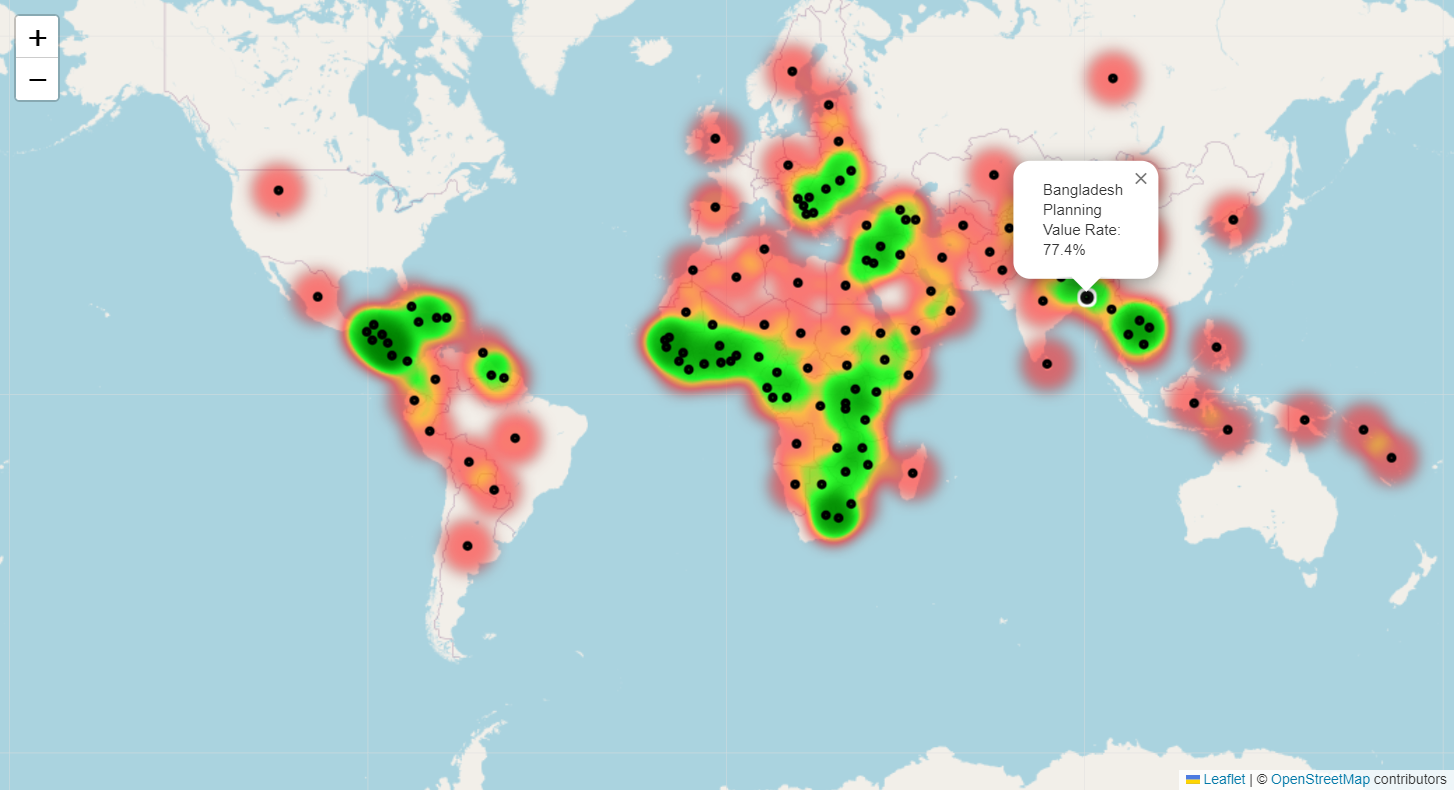

In [137]:
from IPython.display import Image
Image(filename='Extracted_Interactive_Map(HTML File)\Family_planning_value_rate_Heatmap.png')

In [138]:
#RR-Group by Continent and Country, calculate the mean Planning_Value_Rate
continent_country_data = data_with_continents.groupby(['ParentLocation_Continent', 'Country'])['Planning_Value_Rate'].mean().reset_index()

# Sort by Planning_Value_Rate within each Continent group
continent_country_data_sorted = continent_country_data.groupby('ParentLocation_Continent').apply(lambda x: x.nlargest(3, 'Planning_Value_Rate')).reset_index(drop=True)
continent_country_data_sorted

,ParentLocation_Continent,Country,Planning_Value_Rate
0,Africa,Zimbabwe,84.8
1,Africa,Eswatini,82.9
2,Africa,Lesotho,82.8
3,Americas,Nicaragua,89.8
4,Americas,Brazil,89.3
5,Americas,Cuba,86.9
6,Eastern Mediterranean,Egypt,80.0
7,Eastern Mediterranean,Morocco,72.0
8,Eastern Mediterranean,Qatar,68.9
9,Europe,France,95.5


In [139]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(continent_country_data_sorted, how='left', left_on='name', right_on='Country')
m = folium.Map(location=[0, 0], zoom_start=2)
heat_data = [
    [row['geometry'].centroid.y, row['geometry'].centroid.x, row['Planning_Value_Rate']]
    for _, row in world.dropna(subset=['Planning_Value_Rate']).iterrows()
]
HeatMap(
    heat_data,
    gradient={0.0: '#FF0000', 0.6: '#FFFF00', 1.0: '#00FF00'},  # Red to Neon Green gradient
    radius=20,      # Adjust the radius of each point
    blur=10,        # Adjust the blur intensity for smoother heatmap appearance
    min_opacity=0.5,  # Minimum opacity for points
    max_val=float(world['Planning_Value_Rate'].max())  # Maximum value for the heatmap scale
).add_to(m)
folium.Choropleth(
    geo_data=world,
    name="choropleth",
    data=world,
    columns=["iso_a3", "Planning_Value_Rate"],
    key_on="feature.properties.iso_a3",
    fill_color="YlGnBu",  # Red to Green color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Planning Value Rate (%)",
).add_to(m)

# Add markers with tooltips for each country
for _, row in world.dropna(subset=['Planning_Value_Rate']).iterrows():
    folium.Marker(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        popup=f"{row['Country']}<br>Planning Value Rate: {row['Planning_Value_Rate']}%",
        tooltip=f"{row['Country']} - {row['Planning_Value_Rate']}%",
        icon=folium.Icon(color='green', icon='info-sign'),
    ).add_to(m)



m

C:\Users\ranar\AppData\Local\Temp\ipykernel_22412\1841863602.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\ranar\AppData\Local\Temp\ipykernel_22412\1841863602.py:8: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


In [140]:
delay = 5
fn = 'Extracted_Interactive_Map(HTML File)/Top_3_Conyties_planning_value_rate_map.html'

tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

browser = webdriver.Chrome()
browser.get(tmpurl)
time.sleep(delay)

#Take a screenshot of the map
browser.save_screenshot('Extracted_Interactive_Map(HTML File)/Top_3_Countries_planning_value_rate_Heatmap.png')

True

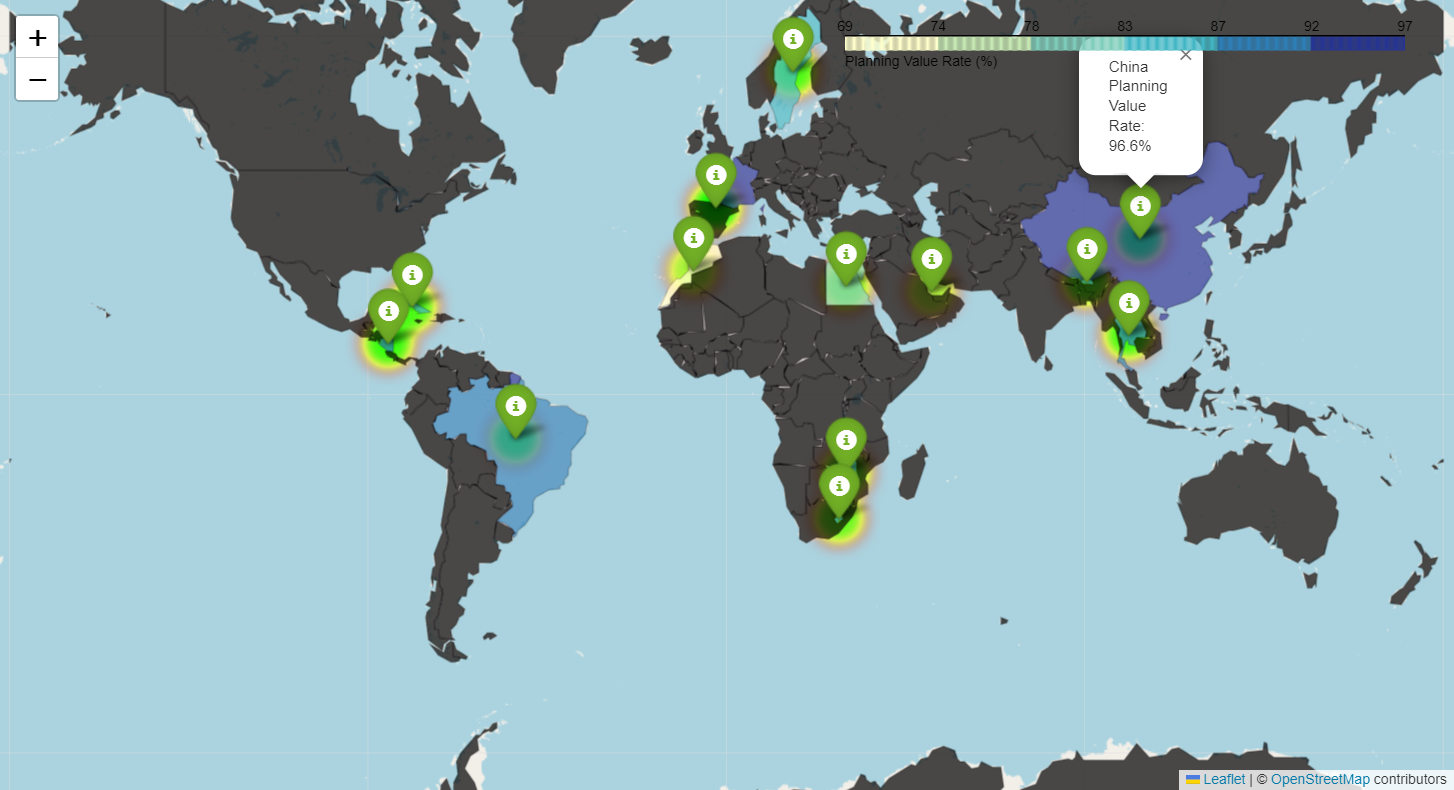

In [141]:
from IPython.display import Image
Image(filename='Extracted_Interactive_Map(HTML File)/Top_3_Countries_planning_value_rate_Heatmap.png')

In [142]:
file_path = "Normalized_Tables\Period_Ranges_Table.csv"
period_ranges= pd.read_csv(file_path)
period_ranges

,Year_Period_Range,PeriodRangeID
0,2021-2023,1
1,2018-2020,2
2,2015-2017,3
3,2012-2014,4
4,2009-2011,5
5,2006-2008,6
6,2003-2005,7
7,Out of Range,8


c:\Users\ranar\.conda\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ranar\.conda\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


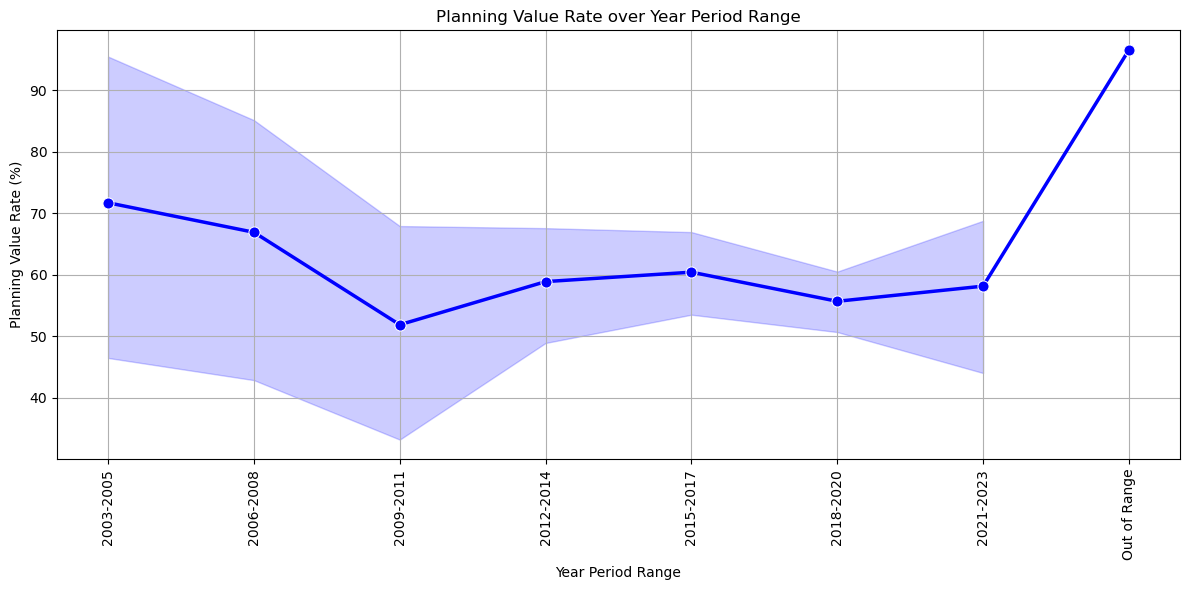

In [143]:
# Merge main_data with Period_Range on PeriodRangeID
merged_data = pd.merge(main_data, period_ranges, on='PeriodRangeID')
merged_data = merged_data.sort_values('Year_Period_Range')

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_data, x='Year_Period_Range', y='Planning_Value_Rate', marker='o', markersize=8, color='b', linewidth=2.5)
plt.title('Planning Value Rate over Year Period Range')
plt.xlabel('Year Period Range')
plt.ylabel('Planning Value Rate (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()